<a href="https://colab.research.google.com/github/TruonghocAI/Cassava_Leaf_Disease/blob/main/Cassava_Leaf_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
!wget --no-check-certificate https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip \
                -O /content/cassavaleafdata.zip


'\n!wget --no-check-certificate https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip                 -O /content/cassavaleafdata.zip\n                '

In [ ]:
!unzip /content/cassavaleafdata.zip

In [ ]:
%cd /content/cassavaleafdata

In [ ]:
data_paths = {
    'train': './train',
    'valid': './validation',
    'test': './test'
}

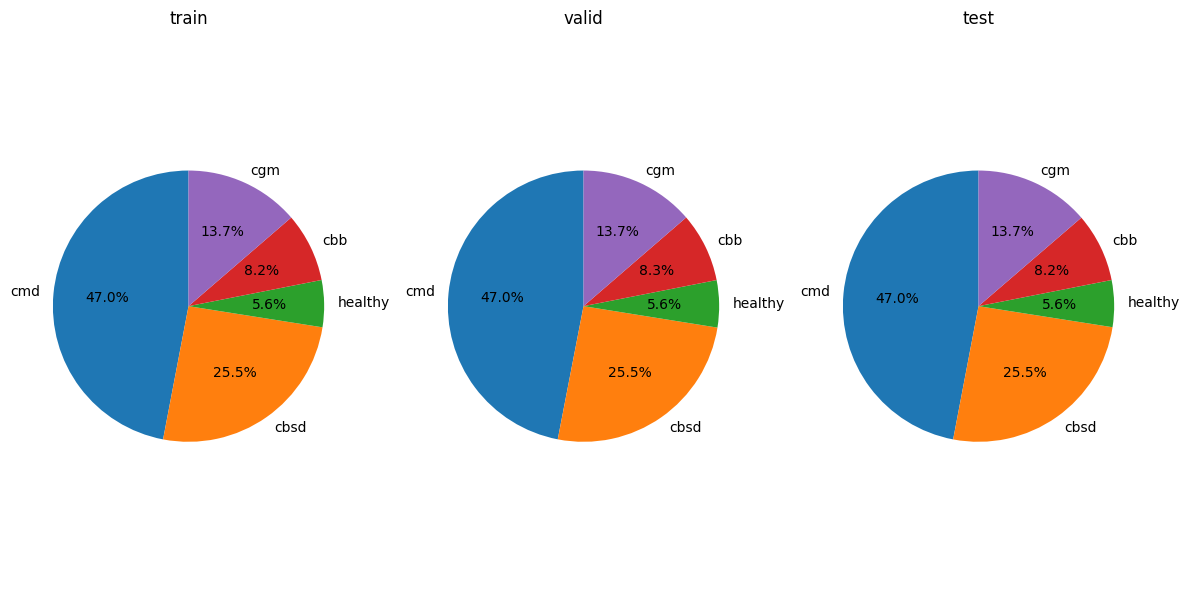

In [ ]:
from imutils import paths
def show_labels(data_paths):
    fig, ax = plt.subplots(1, len(data_paths), figsize=(12, 6))
    for idx, (key, sub_dir) in enumerate(data_paths.items()):
        labels = os.listdir(sub_dir)
        list_data = []
        for label in labels:
            image_files = list(paths.list_images(os.path.join(sub_dir, label)))
            list_data.append(len(image_files))
        ax[idx].pie(list_data, labels=labels, autopct='%1.1f%%', startangle=90)
        ax[idx].axis('equal')
        ax[idx].set_title(key)
    plt.tight_layout()
    plt.show()

show_labels(data_paths)

In [ ]:
labels_dict = {
    "cbb": "Bệnh cháy lá vi khuẩn sắn (CBB)",
    "cbsd": "Bệnh sọc nâu trên sắn (CBSD)",
    "cgm": "Bệnh đốm xanh trên sắn (CGM)",
    "cmd": "Bệnh khảm lá sắn (CMD)",
    "healthy": "Cây khỏe mạnh"
}

In [ ]:
def show_images(data_dir, label, num_sample=6):
    data_dir = os.path.join(data_dir, label)
    image_files = list(paths.list_images(data_dir))[:num_sample]
    fig, ax = plt.subplots(2,num_sample//2, figsize=(14,7))
    for i, image_dir in enumerate(image_files):
        img = Image.open(image_dir)
        label = image_dir.split('/')[-2]
        ax[i//(num_sample//2)][i%(num_sample//2)].imshow(img)
        ax[i//(num_sample//2)][i%(num_sample//2)].set_title(labels_dict[label])
        ax[i//(num_sample//2)][i%(num_sample//2)].axis('off')
    plt.tight_layout()
    plt.show()

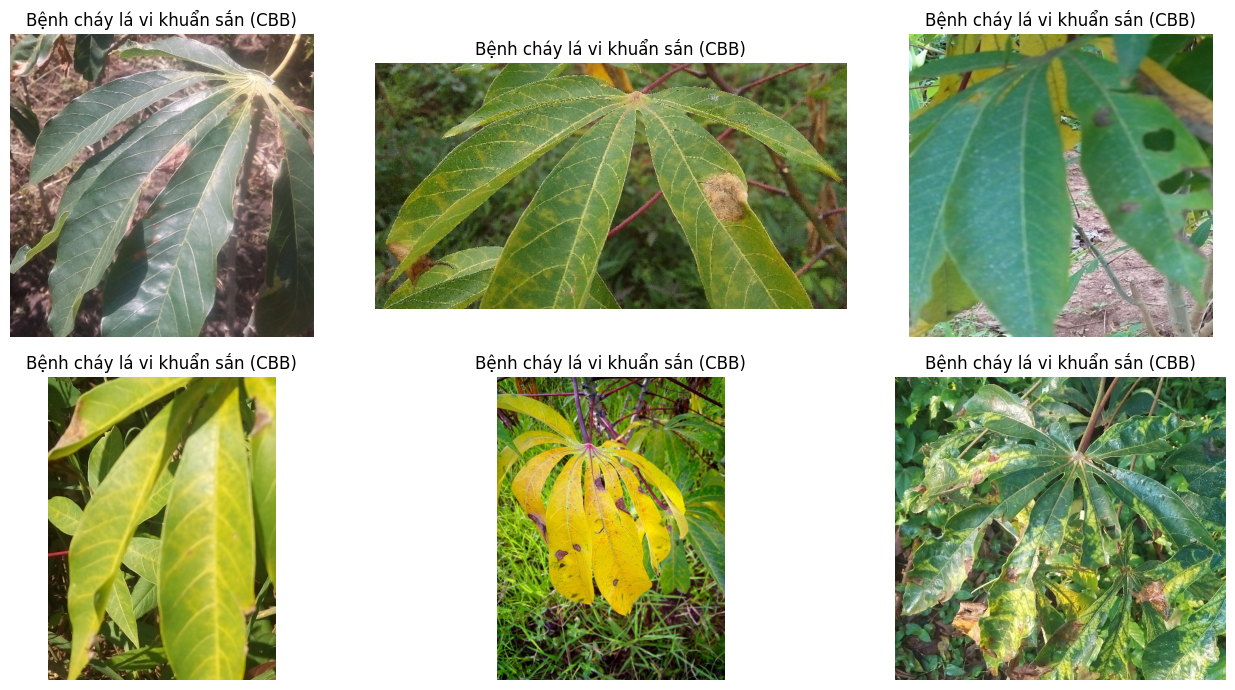

In [ ]:
show_images(data_paths['train'], label="cbb")

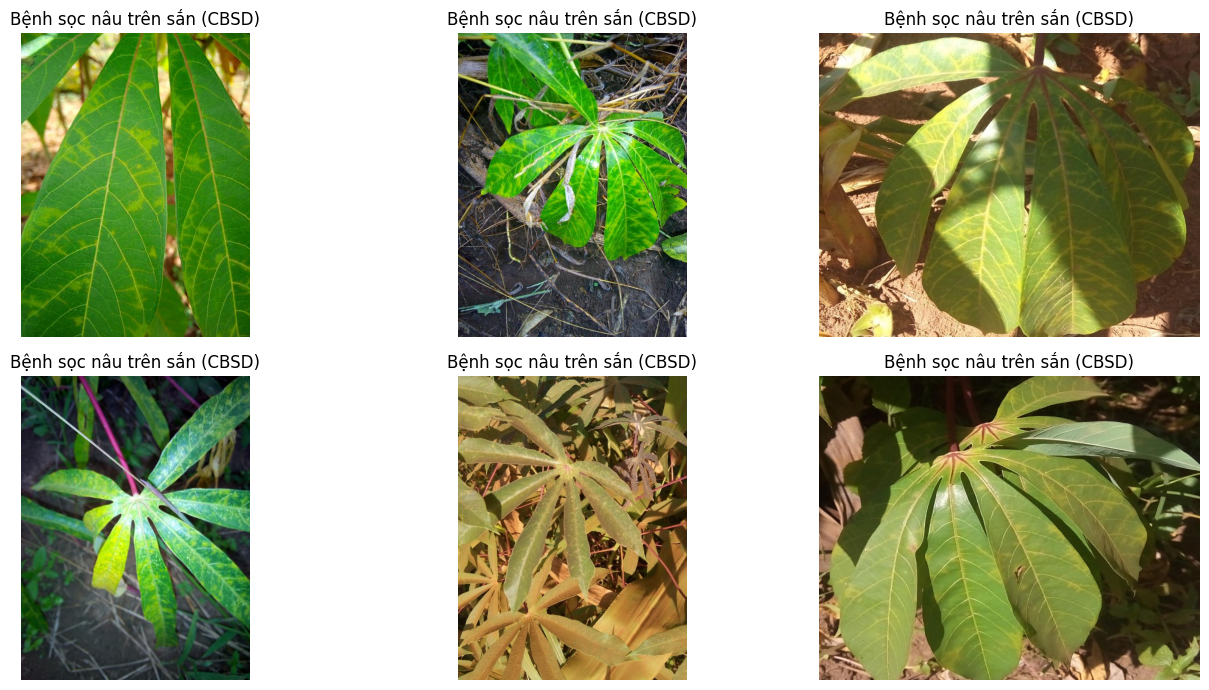

In [ ]:
show_images(data_paths['train'], label="cbsd")

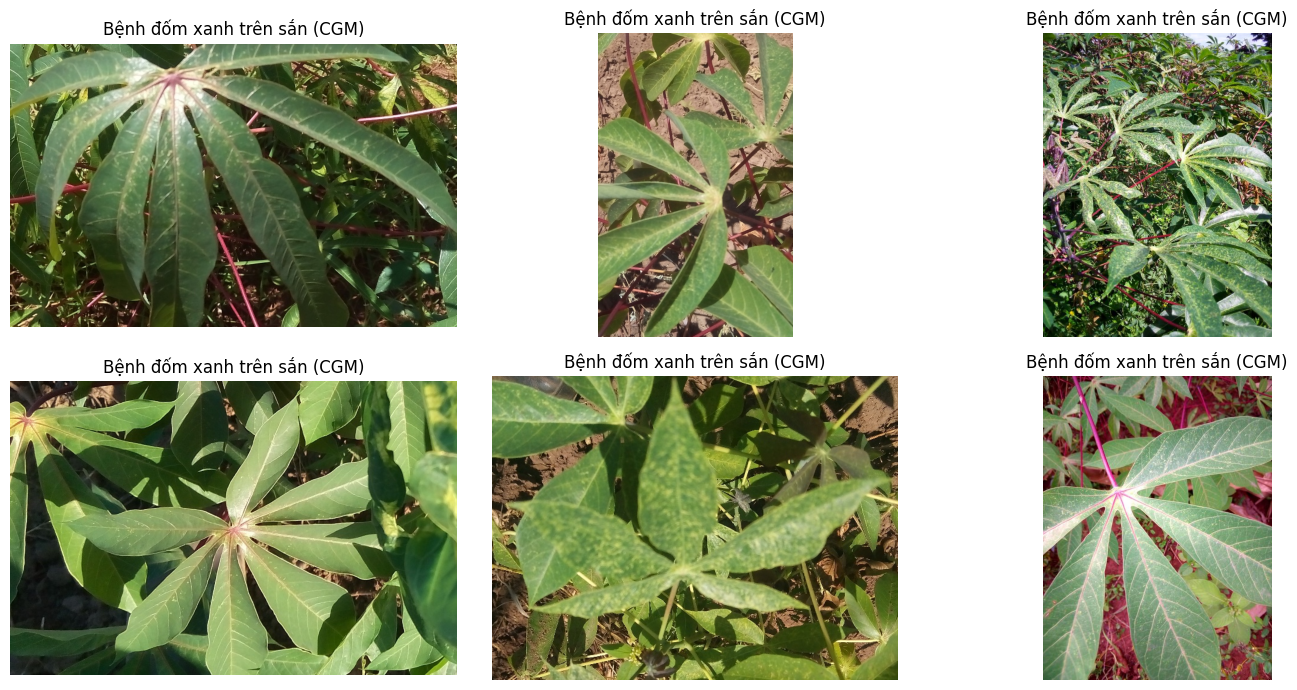

In [ ]:
show_images(data_paths['train'], label="cgm")

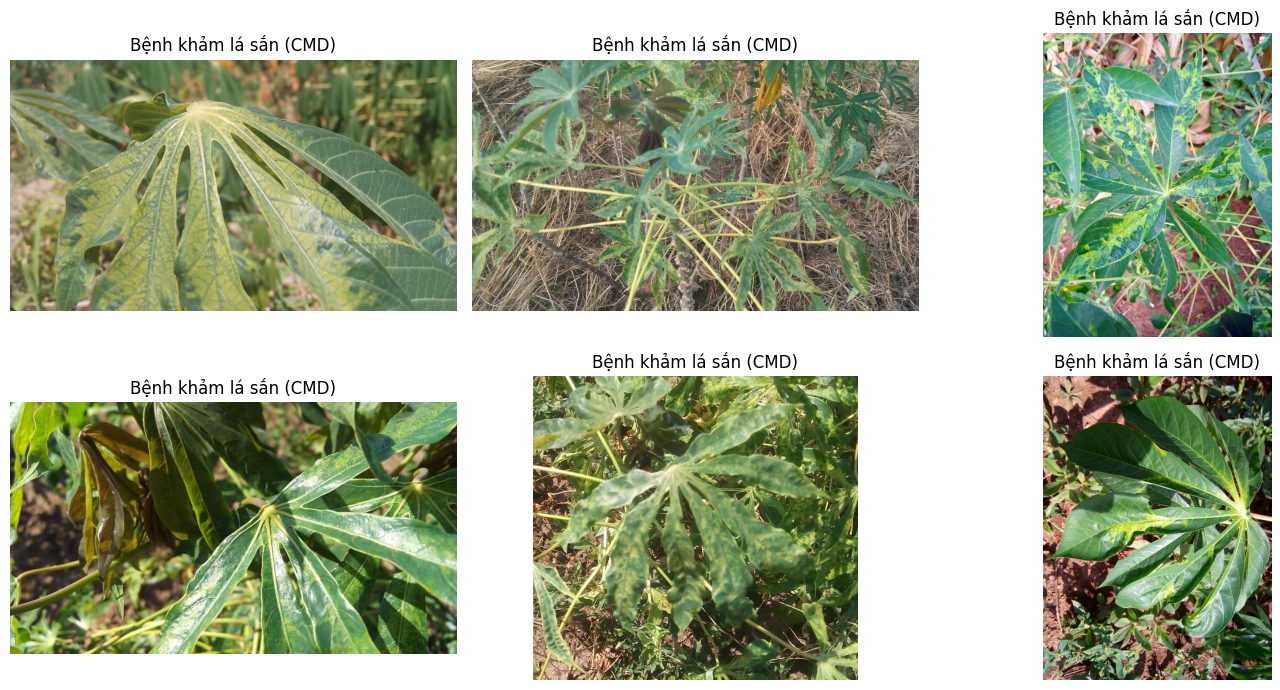

In [ ]:
show_images(data_paths['train'], label="cmd")

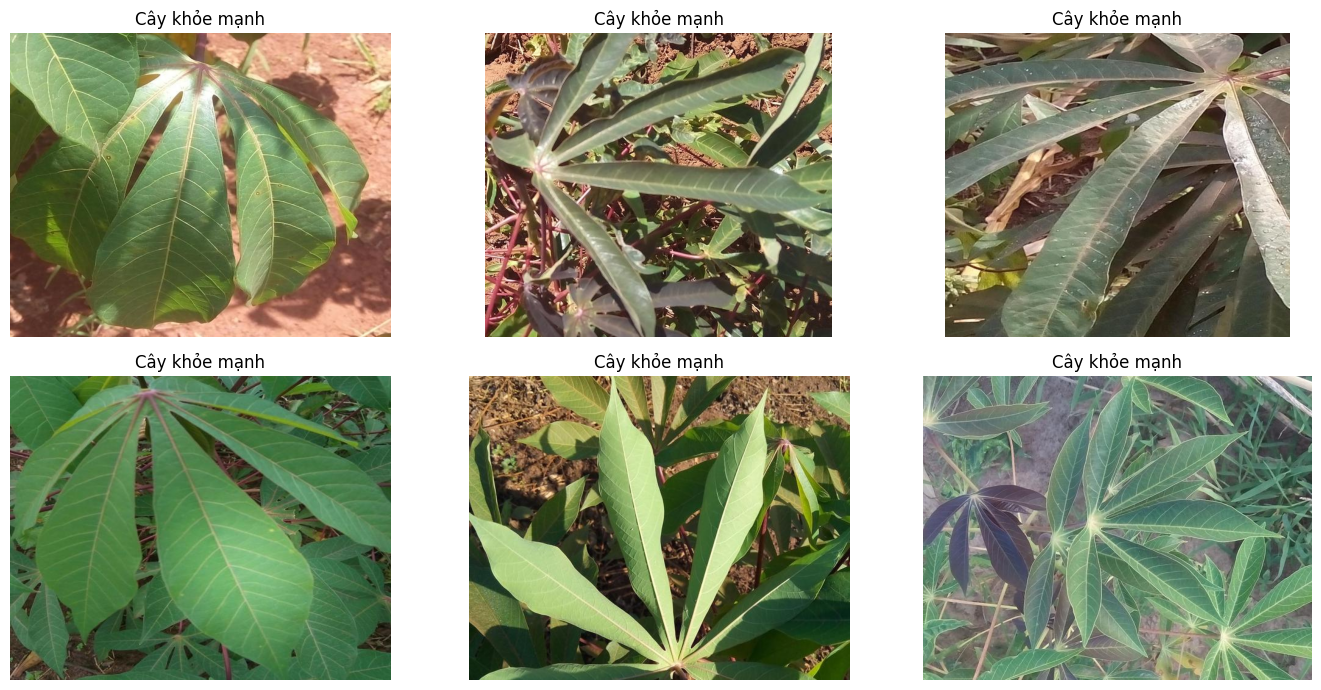

In [ ]:
show_images(data_paths['train'], label="healthy")

##**Preprocessing**

In [ ]:
def loader(path):
    return Image.open(path)

In [ ]:
img_size = 150
train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

In [ ]:
train_data = datasets.ImageFolder(
    root=data_paths['train'],
    loader=loader,
    transform=train_transforms
)
valid_data = datasets.ImageFolder(
    root=data_paths['valid'],
    transform=train_transforms
)
test_data = datasets.ImageFolder(
    root=data_paths['test'],
    transform=train_transforms
)

##**Dataloader**


In [ ]:
BATCH_SIZE = 512

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)
valid_dataloader = data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE
)
test_dataloader = data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)

In [ ]:
len(train_dataloader)

12

In [ ]:
inputs, labels = next(iter(train_dataloader))

In [ ]:
inputs.shape

torch.Size([512, 3, 150, 150])

## **LeNet Model**

In [ ]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=6, kernel_size=5, padding='same'
        )
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(16 * 35 * 35, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)
        outputs = self.flatten(outputs)
        outputs = self.fc_1(outputs)
        outputs = self.fc_2(outputs)
        outputs = self.fc_3(outputs)
        return outputs


In [ ]:
num_classes = len(train_data.classes)
num_classes

5

In [ ]:
lenet_model = LeNetClassifier(num_classes)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lenet_model.to(device)

LeNetClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_1): Linear(in_features=19600, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=5, bias=True)
)

In [ ]:
summary(lenet_model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 150, 150]             456
         AvgPool2d-2            [-1, 6, 75, 75]               0
            Conv2d-3           [-1, 16, 71, 71]           2,416
         AvgPool2d-4           [-1, 16, 35, 35]               0
           Flatten-5                [-1, 19600]               0
            Linear-6                  [-1, 120]       2,352,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                    [-1, 5]             425
Total params: 2,365,581
Trainable params: 2,365,581
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 2.20
Params size (MB): 9.02
Estimated Total Size (MB): 11.48
----------------------------------------------------------------


## **Trainer**

In [ ]:
optimizer = optim.Adam(lenet_model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
import time

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=15):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # forward
        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()

        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device)

In [ ]:
train_acc, train_loss

(0.47065063649222066, 1.3795545796553295)

In [ ]:
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)

In [ ]:
eval_acc, eval_loss

(0.4695606140815246, 1.3602295368909836)

##**Training**

In [ ]:
num_classes = len(train_data.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
learning_rate = 2e-4
optimizer = optim.Adam(lenet_model.parameters(), learning_rate)

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100
os.makedirs(save_model, exist_ok=True)

In [ ]:
for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device, epoch, log_interval=10)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        torch.save(lenet_model.state_dict(), save_model + '/lenet_model.pt')

    # Print loss, acc end epoch
    print("-" * 120)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 120)

    # Load best model
    lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pt', weights_only=True))
    lenet_model.eval()

| epoch   1 |    10/   12 batches | accuracy    0.471
------------------------------------------------------------------------------------------------------------------------
| End of epoch   1 | Time: 50.63s | Train Accuracy    0.292 | Train Loss    1.392 | Valid Accuracy    0.468 | Valid Loss    1.386 
------------------------------------------------------------------------------------------------------------------------
| epoch   2 |    10/   12 batches | accuracy    0.466
------------------------------------------------------------------------------------------------------------------------
| End of epoch   2 | Time: 51.67s | Train Accuracy    0.542 | Train Loss    1.356 | Valid Accuracy    0.470 | Valid Loss    1.337 
------------------------------------------------------------------------------------------------------------------------
| epoch   3 |    10/   12 batches | accuracy    0.469
--------------------------------------------------------------------------------------------

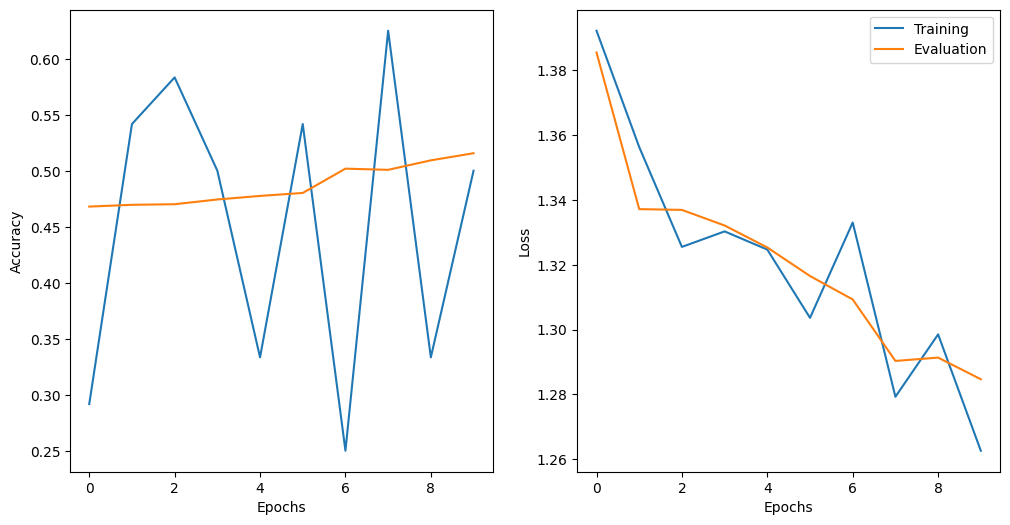

In [ ]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")

    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")

    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)

In [ ]:
test_acc, test_loss = evaluate(lenet_model, criterion, test_dataloader, device)
test_acc, test_loss

(0.5289124668435013, 1.270724043250084)

## **Predict**

In [ ]:
def load_model(model_path, num_classes=5):
    lenet_model = LeNetClassifier(num_classes)
    lenet_model.load_state_dict(torch.load(model_path, weights_only=True))
    lenet_model.eval()
    return lenet_model

def inference(img_path, model):
    image = Image.open(img_path)
    img_size = 150

    img_transform = torchvision.transforms.Compose.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
    ])
    img_new = img_transform(image)
    img_new = torch.unsqueeze(img_new, 0)
    with torch.no_grad():
        predictions = model(img_new)
    preds = nn.Softmax(dim=1)(predictions)
    p_max, yhat = torch.max(preds.data, 1)
    print(f'Xác suất {round(p_max.item()*100,4)}% cây trồng mắc : ')

    if yhat.item() == 0:
        print("Bệnh cháy lá vi khuẩn sắn (CBB)")
        print("Nguyên gây bệnh: Vi khuẩn sắn")
        print("Biểu hiện: Vàng úa, héo, đốm nâu")
        print("Ảnh hưởng bệnh đến cây trồng: Giảm năng suất, héo rụng lá")
        print("Phương án khắc phục: Trồng giống kháng bệnh, vệ sinh đồng ruộng, phun thuốc chứa đồng")

    elif yhat.item() == 1:
        print("Bệnh sọc nâu trên sắn (CBSD)")
        print("Nguyên gây bệnh: Virus CBSD")
        print("Biểu hiện: Sọc nâu, lá biến dạng")
        print("Ảnh hưởng bệnh đến cây trồng: Thối củ, giảm năng suất nghiêm trọng")
        print("Phương án khắc phục: Dùng giống kháng, kiểm soát rệp sáp, tiêu hủy cây bệnh")

    elif yhat.item() == 2:
        print("Bệnh đốm xanh trên sắn (CGM)")
        print("Nguyên gây bệnh: Virus hoặc điều kiện môi trường")
        print("Biểu hiện: Loang lổ xanh nhạt, xanh đậm")
        print("Ảnh hưởng bệnh đến cây trồng: Ảnh hưởng nhẹ đến trung bình")
        print("Phương án khắc phục: Cải thiện điều kiện chăm sóc, dùng giống kháng, phun thuốc phù hợp.")

    elif yhat.item() == 3:
        print("Bệnh khảm lá sắn (CMD)")
        print("Nguyên gây bệnh: Virus CMD")
        print("Biểu hiện: Loang lổ, lá xoắn, cong")
        print("Ảnh hưởng bệnh đến cây trồng: Giảm năng suất nghiêm trọng, cây còi cọc")
        print("Phương án khắc phục: Trồng giống sạch bệnh, kiểm soát rệp sáp, nhổ bỏ cây nhiễm bệnh.")

    elif yhat.item() == 4:
        print("Cây khỏe mạnh")
        print("Biểu hiện: Xanh tươi, lá bình thường")
        print("Ảnh hưởng bệnh đến cây trồng: Năng suất cao, cây phát triển bình thường")
        print("Phương án khắc phục: Trồng giống sạch bệnh, kiểm soát rệp sáp, nhổ bỏ cây nhiễm bệnh.")


Hình ảnh cây trồng


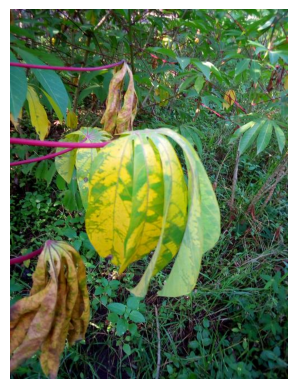

NameError: name 'torchvision' is not defined

In [ ]:
path = '/content/cassavaleafdata/test/cbsd/test-cbsd-114.jpg'
print('Hình ảnh cây trồng')
img = Image.open(path)
plt.imshow(img)
plt.axis('off')
plt.show()
print()
model = load_model('./model/lenet_model.pt')
preds = inference(path, model)
preds